# Wikipedia Talk Data - Getting Started

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

## Q & A

The following code runs Python 3 and integrates Imblearn.

**What text cleaning methods did you try? Which are the ones you included in the final code?**

All the methods that I have tried were included in the code. I removed punctuation and extra spaces. In the vectorizer, I removed stop words and lowercased all tokens. I attempted a spellchecker, but that included the use of an API and more time. Unfortantely, I was not able to get that working.

**What are the features you considered using? Which features did you use in the final code?**

I considered using different n-grams for both word and character. I attempted different token patterns. I attempted different max features and included a library of stop words. Ultimately, the stop words, unigram, and max feature included in the code were the best results.

**How did you decide to use the ‘attack’ information from different annotators? Did you average them, or use a number threshold, or did you use some other method to use this information?**

I combined the training and development set and chose an average of above 0.5. As long as the majority of annontators agreed that the comment was an attack, than it should suffice to say that it was an attack. This would allow for less unbalanced combination. If I was stricter, say 0.9, this could lead to heavily unbalanced majority bias.

**What optimizations did you add in your code, if any?**

I used a imblearn pipeline with grid search parameters so that I can insert oversampling and undersampling into the pipeline. This also allowed me to use a formatted list of hyperparameters and implement cross validation.

**What are the ML methods you tried out, and what were your best results with each method? Which was the best ML method you saw before tuning hyperparameters?**

I tried all the linear models, gradient boosting, and tree models. I even tried using imblearn and added over and under sampling while generating artifical data. The best method, before hyperparameters, in Sklearn was definitely using decision tree classifiers, as they can deal with the imbalanced data better. However, Imblearn models provided more of an advantage in terms of samping and data generation which improved accuracy.

**What hyper-parameter tuning did you do, and by how many percentage points did your accuracy go up because of hyper-parameter tuning?**

For the randomforest classifier model, I tuned the max depth of the tree and the weight of the data. This greatly increased the recall from the strawman model; however, overall accuracy went down a little bit. For the imblearn model, I chose to sample 3 to 4 neighbors when generating artificial data. I also assigned custom sampling strategies for both over and undersampling and replaced the sampling. This definitely increased the auc roc of the model by 0.02 points.

**What did you learn from the different metrics? Did you try cross-validation?**

I did attempt cross-validation with GridSearchCV. This made the process easier. The problem with the dataset is that it is heavily imbalanced making the learning algorithm bias toward the majority data. Therefore, AUC ROC scores mean very little if the majority data is always leaning toward False. Therefore, I needed to look at the confusion matrix, precision, and recall values which indicate how many False Positives and False Negatives would be included in the output. This will help determine how to evaluate the performance of the algorithm. In my efforts, I tried my best to keep precision and recall leveled for True while maintaining the integrity of False values. This would hopefully, allow for equally less FN and FP. If the precision is high and the recall low for True, the algorithm would most likely predict more FP. This would be the opposite for FN, where precision is low and recall is high.

**What are your best final Result Metrics? What is the increase in accuracy compared to the strawman figure? Which model gave you this performance?**

There was a tremendous increase in recall for Attacks and increase in ROC score; however, the accuracy increased by very little. This resulted from the fact that it was already very high to begin with. Overall, this was a trade off for an increase in False Positives, or indicating a comment as an attack when it was not an attack. Where the strawman model could only predict half of the actual attacks as attacks, the improved model using over and under sampling was able to predict 80% of the attacks.

**What is the most interesting thing you learned from doing the report?**

There are various ways to deal with balanced and unbalanced data. While all methods produced varying results, the context and goal behind how you will use the data impacts how you want to arrive at the results. For example, for our model, the goal could be that we want to flag attacks, but not at the risk of flagging regular comments as attacks. Therefore, we would probably want to go with a model that produces a higher precision score for attacks. I chose to go the route that allows for more accurately labeled attacks at the risk of flagging regular comments as attacks. For unbalanced data, there are models to generate artificial data that could balance the data and help the algortihm perform better. Ultimately, there is no perfect algorithm and there will always be False Negatives or False Positives in the confusion matrix.

**What was the hardest thing to do?**

Hyperparameter tuning was the most difficult. The parameters had very little or cryptic documentation for some of them. At times, it felt like trial and error. Thus, the more folds or fits that occurs, the longer you have to wait to retrieve the results from the model. All of the models from Sklearn either increased recall but reduced precision or vice versa. I was unable to get the precision and recall to a high level. Imblearn allowed me to achieve this more accurately, although still not to the level that I would expect in this model.

## Building a classifier for personal attacks
In this section we will train a simple bag-of-words classifier for personal attacks using the [Wikipedia Talk Labels: Personal Attacks]() data set.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import urllib.request, urllib.parse, urllib.error

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

## Import data
Use this section to import the data if you have not downloaded the files

In [4]:
# download annotated comments and annotations
ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

                
# download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
# download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [5]:
# reading the data
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

## Labeling Data
The data is labeled based on majority vote of which comments are attack.

In [6]:
# labels a comment as an attack if the majority of annoatators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [7]:
# join labels and comments
comments['attack'] = labels

## Visualizing Data
Plotting the data to get a better understanding of the balance. Here we see that there is a heavy imbalance of comments marked as attack versus not attacks. The data requires a use of strategies that work better for imbalanced datasets.

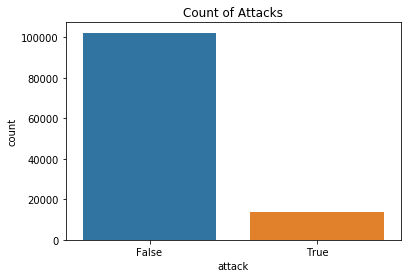

In [8]:
# plotting the attacks
fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='attack', data=comments)
plt.title("Count of Attacks")
plt.show()

## Cleaning Data
Extranneous information is removed from the comments. Here we removed unimportant tokens for new lines and tabs. The data is split up into two groups, one for training and the other for testing. Since the data is heavily imbalanced, we required additional data points from another table.

In [9]:
# remove newline, tab tokens, punctuation, and extra white spaces
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
comments['comment'] = comments['comment'].str.replace(' +', ' ')
comments['comment'] = comments['comment'].str.replace('[^\w\s]', ' ')

# splitting the data
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

# bulking up the data
dev_comments = comments.query("split=='dev'")
attack_comments = dev_comments.query("attack==True")
train_new_comments = train_comments.append(attack_comments)

## Imblearn Pipelines
Here we add a pipeline with hyperparamaters that take advantage of imblearn's under and over sampling strategies. The pipeline also generates artificial data with SMOTE and runs it through a classifier.

In [10]:
# hyperparameters for the pipline
param_grid = { 
    "feature_union__vect_word__analyzer": ['word'],
    "feature_union__vect_word__token_pattern": [r'\w{1,}'],
    "feature_union__vect_word__max_features": [10000],
    "feature_union__vect_word__lowercase": [True],
    "feature_union__vect_word__stop_words": [text.ENGLISH_STOP_WORDS],
    "feature_union__vect_word__ngram_range": [(1,1),(1,2)],
    "feature_union__vect_word__max_df": [1.0],
    "feature_union__vect_word__min_df": [1],
    "smote__k_neighbors": [3,4],
    "smote__sampling_strategy": [0.3, 0.2],
    "undersample__replacement": [True],
    "undersample__sampling_strategy": [0.7, 0.8]
}

feature_union = ('feature_union', FeatureUnion([
    ('vect_word', TfidfVectorizer()),
    ('vect_char', TfidfVectorizer()),
]))

# pipline for vectorizer, smote, undersampler, and classifier
clf = Pipeline(steps=[
    feature_union,
    ('smote', SMOTE()),
    ('undersample',RandomUnderSampler()),
    ('classifier', LogisticRegression(max_iter=10000))])

# grid search 
grid_search = GridSearchCV(clf, 
                           param_grid=param_grid, 
                           verbose=10, 
                           n_jobs=-1)

## Fitting and Scoring
Here we fit the model and print out the scores to see how well the model generalizes.

In [11]:
# fit the model
clf_grid = grid_search.fit(train_new_comments['comment'], train_new_comments['attack'])

# true values and predictions
truevals = test_comments['attack']
prd = clf_grid.predict(test_comments['comment'])

auc = roc_auc_score(test_comments['attack'], clf_grid.predict_proba(test_comments['comment'])[:, 1])

# print scores
print(classification_report(truevals, prd))
print(confusion_matrix(truevals, prd))
print('Test ROC AUC: %.3f' %auc)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:  7.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  75 out of  80 | elapsed:  7.1min remaining:   28.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  7.5min finished


              precision    recall  f1-score   support

       False       0.97      0.95      0.96     20422
        True       0.70      0.80      0.75      2756

    accuracy                           0.94     23178
   macro avg       0.84      0.88      0.86     23178
weighted avg       0.94      0.94      0.94     23178

[[19491   931]
 [  556  2200]]
Test ROC AUC: 0.960


## Examples
Demo of how the classifier works.

In [12]:
# correctly classify nice comment
clf_grid.predict(['Thanks for you contribution, you did a great job!'])

array([False])

In [14]:
# correctly classify nasty comment
clf_grid.predict(['I hate you so much! Go to Hell.'])

array([ True])

## Sklearn Pipelines
Here we model the data using Sklearn's resampling for comparison.

In [17]:
# hyperparameters for the pipline
sklearn_param_grid = { 
    "vect_word__analyzer": ['word'],
    "vect_word__token_pattern": [r'\w{1,}'],
    "vect_word__max_features": [10000],
    "vect_word__lowercase": [True],
    "vect_word__stop_words": [text.ENGLISH_STOP_WORDS],
    "vect_word__ngram_range": [(1,2),(1,3)],
    "vect_word__max_df": [1.0],
    "vect_word__min_df": [1],
    "classifier__max_depth": [20],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__n_estimators": [1000],
    "classifier__class_weight": [{0:1,1:5}]
}

# pipline for vectorizer, resampling, and classifier
sklearn_clf = Pipeline(steps=[
    ('vect_word', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())])

# grid search 
sklearn_grid_search = GridSearchCV(sklearn_clf, 
                           param_grid=sklearn_param_grid, 
                           verbose=10, 
                           n_jobs=-1)

## Sklearn Fitting and Scoring
Here we fit the model and print out the scores to see how well the model generalizes.

In [18]:
# fit the model
sklearn_clf_grid = sklearn_grid_search.fit(train_new_comments['comment'], train_new_comments['attack'])

# true values and predictions
truevals = test_comments['attack']
prd = sklearn_clf_grid.predict(test_comments['comment'])

auc = roc_auc_score(test_comments['attack'], sklearn_clf_grid.predict_proba(test_comments['comment'])[:, 1])

# print scores
print(classification_report(truevals, prd))
print(confusion_matrix(truevals, prd))
print('Test ROC AUC: %.3f' %auc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  2.8min remaining: 15.6min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:  3.0min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  3.2min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  3.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  4.8min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  5.1min remaining:   33.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.1min finished


              precision    recall  f1-score   support

       False       0.95      0.98      0.96     20422
        True       0.81      0.60      0.69      2756

    accuracy                           0.94     23178
   macro avg       0.88      0.79      0.83     23178
weighted avg       0.93      0.94      0.93     23178

[[20039   383]
 [ 1103  1653]]
Test ROC AUC: 0.901
